# Libraries import

In [1]:
!pip install pmdarima --q

In [2]:
# Magic function that will make your plot outputs appear and be stored within the notebook
%matplotlib inline

# Function used to to render higher resolution images
%config InlineBackend.figure_format = 'retina'

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
import random

# Data manipulation
import os
import pandas as pd
import numpy as np
from datetime import datetime, date 

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

# Standardizing the style for the visualizations 
sns.set_theme()
sns.set_palette("pastel")
plt.style.use('seaborn-whitegrid')

# Machine learning models and utilities 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm
from prophet import Prophet
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Dataset import and data description 

In [7]:
# Reading dataset .csv file
df=pd.read_csv("DailyDelhiClimateTrain.csv")

**DailyDelhiClimateTrain.csv** -  This file contains weather data collected in the city of Delhi from the period of 4 months (2017). It can be used for the purpose of forecasting. This is purely academic dataset and is developed as a part of Data Analytics course of 2019.

* **date** (object) - Date of format YYYY-MM-DD.

* **meantemp** (float64) - Mean temperature averaged out from multiple 3 hour intervals in a day.

* **humidity** (float64) -  Humidity value for the day (units are grams of water vapor per cubic meter volume of air).

* **wind_speed** (float64) - Wind speed measured in kmph.

* **meanpressure** (float64) - Pressure reading of weather (measure in atm).


In [8]:
# Dataset sneak peek
df.head(3).append(df.tail(3))

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


Next, we will determine the length of the dataset.

In [9]:
# Dataset length
print('The total number of rows in the dataset is: ',len(df))

The total number of rows in the dataset is:  1462


It appears that the date column is in string format. Let's investigate.

In [10]:
# Date original data type
type(df['date'][0])

str

To make the date column useful, we will proceed to transform it into a Timestamp format.

In [11]:
# Transforming date(str) to Timestamp format
df['date'] =pd.to_datetime(df['date'], format = '%Y/%m/%d')
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Before proceeding with Exploratory Analysis and Data Engineering, let's check if any of our columns have missing values.

In [12]:
# Table showing the number of missing values and percentage 
# of missing values in the current dataset
dict = {}
for i in list(df.columns):
    dict[i] = (df[i].isnull().sum(),round(df[i].isnull().sum()/len(df)*100,2))
 
pd.DataFrame(dict,index=["# of missing values","% of missing values"]).transpose().sort_values(by=["# of missing values"], ascending=False)

,# of missing values,% of missing values
date,0.0,0.0
meantemp,0.0,0.0
humidity,0.0,0.0
wind_speed,0.0,0.0
meanpressure,0.0,0.0


# Exploratory Analysis and Data Engineering

To get a sense of what we are working with, let's plot each feature over time.

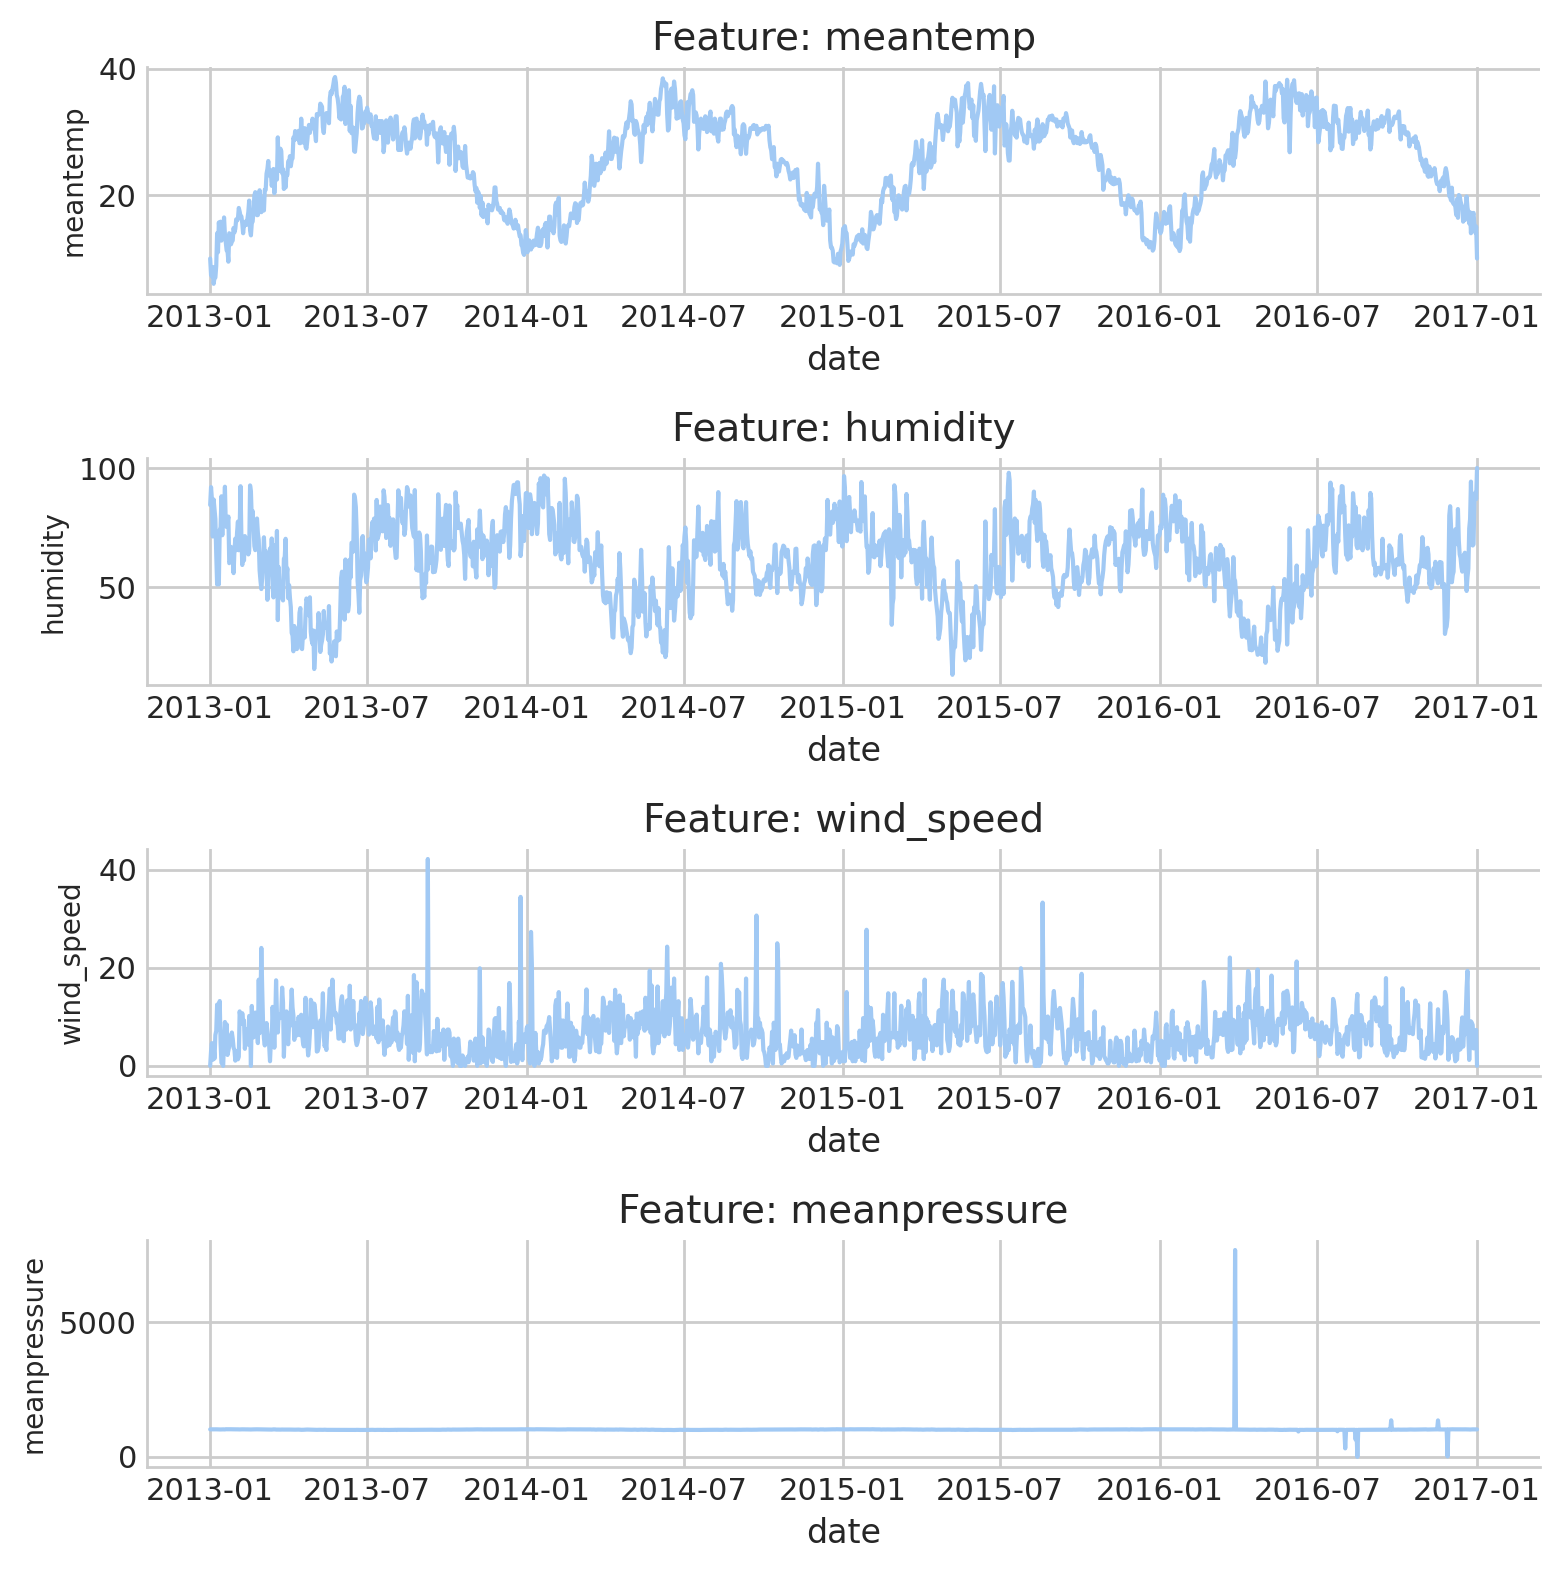

In [13]:
# Plotting each of the time series 
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8)) 
sns.despine()

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i])
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=10)
    
plt.tight_layout()

After examining the meanpressure graph, it appears that we have some abnormal readings. To obtain a better visualization, we will define a function that temporarily removes outliers.

Aside from the meanpressure outliers, it seems that our time series are stationary, with little variation and a constant trend.

In [14]:
# Function for outlier removal
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [15]:
# Applying remove_outlier fuction to meanpressure feature
mean_pre= remove_outlier(df, 'meanpressure')

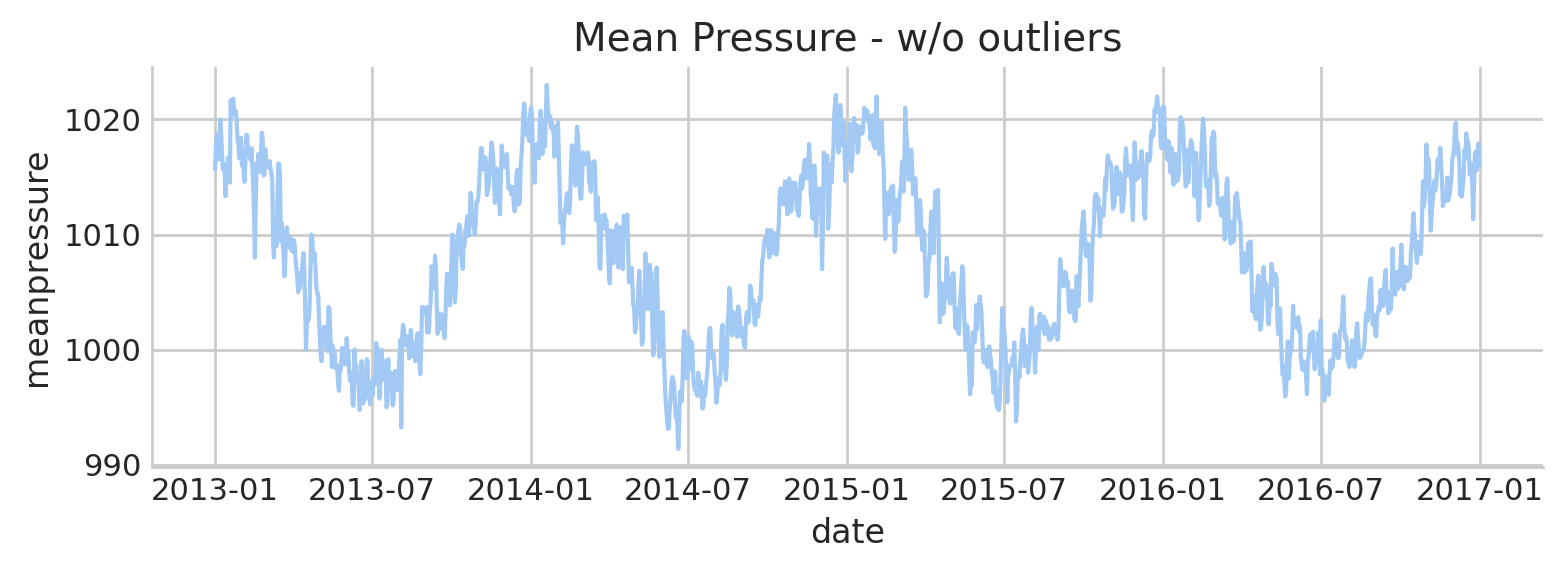

In [16]:
# Plotting meaenpressure w/o outliers for a better visualization 
fig, ax =plt.subplots(figsize=(8,3)) 
sns.despine()
ax.set_title('Mean Pressure - w/o outliers', size=14)
sns.lineplot(data=mean_pre,x='date',y='meanpressure')

plt.tight_layout()

We need to replace the erroneous readings (outliers) so that our data is accurate. One way to achieve this is by interpolating.


In [17]:
# Replacing outliers with NaN values 
def replace_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    
    df_in.loc[(df[col_name]<q1-1.5*iqr) | (df[col_name]>q3 + 1.5*iqr),col_name] = np.nan
    
    return df_in

In [18]:
# Applying replace_outliers function to meanpressure 
df = replace_outliers(df,'meanpressure' ) 

In [19]:
# Quantifying how many NaN value we have after replace_outliers was applied
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 9


In [20]:
# Interpolating meanpressure NaN values 
df['meanpressure'] = df['meanpressure'].interpolate()

In [21]:
# meanpressure NaN values after interpolation 
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 0


Great, we are almost ready to perform an ADF test on the time series. However, before doing so, let's downsample our dataset to help smooth the curve.

In [22]:
# Downsampling dataset Days -> Week 
downsample = df[['date',
                 'meantemp', 
                 'humidity',
                 'wind_speed', 
                 'meanpressure'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

Let's check how many samples we have available now.

In [23]:
# Number of rows of the dataset adter downsampling
print('The total number of rows dataset after downsampling: ',len(df))

The total number of rows dataset after downsampling:  209


To perform the ADF test, we define a function that allows us to visualize the results:

* A green curve indicates that our ADF statistic is below 1% of the critical value (time series is stationary).

* A blue curve indicates that our ADF statistic is above 1% of the critical value but below 5% of the critical value (time series is stationary).

* A red curve indicates that our ADF statistic is above 5% of the critical value (time series is not stationary), and we need to apply transformations to make it stationary.

We perform this test to ensure that our time series is stationary and can be fed successfully into the ARIMA model.

In [24]:
# Function to visualize Augmented Dickey–Fuller test
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

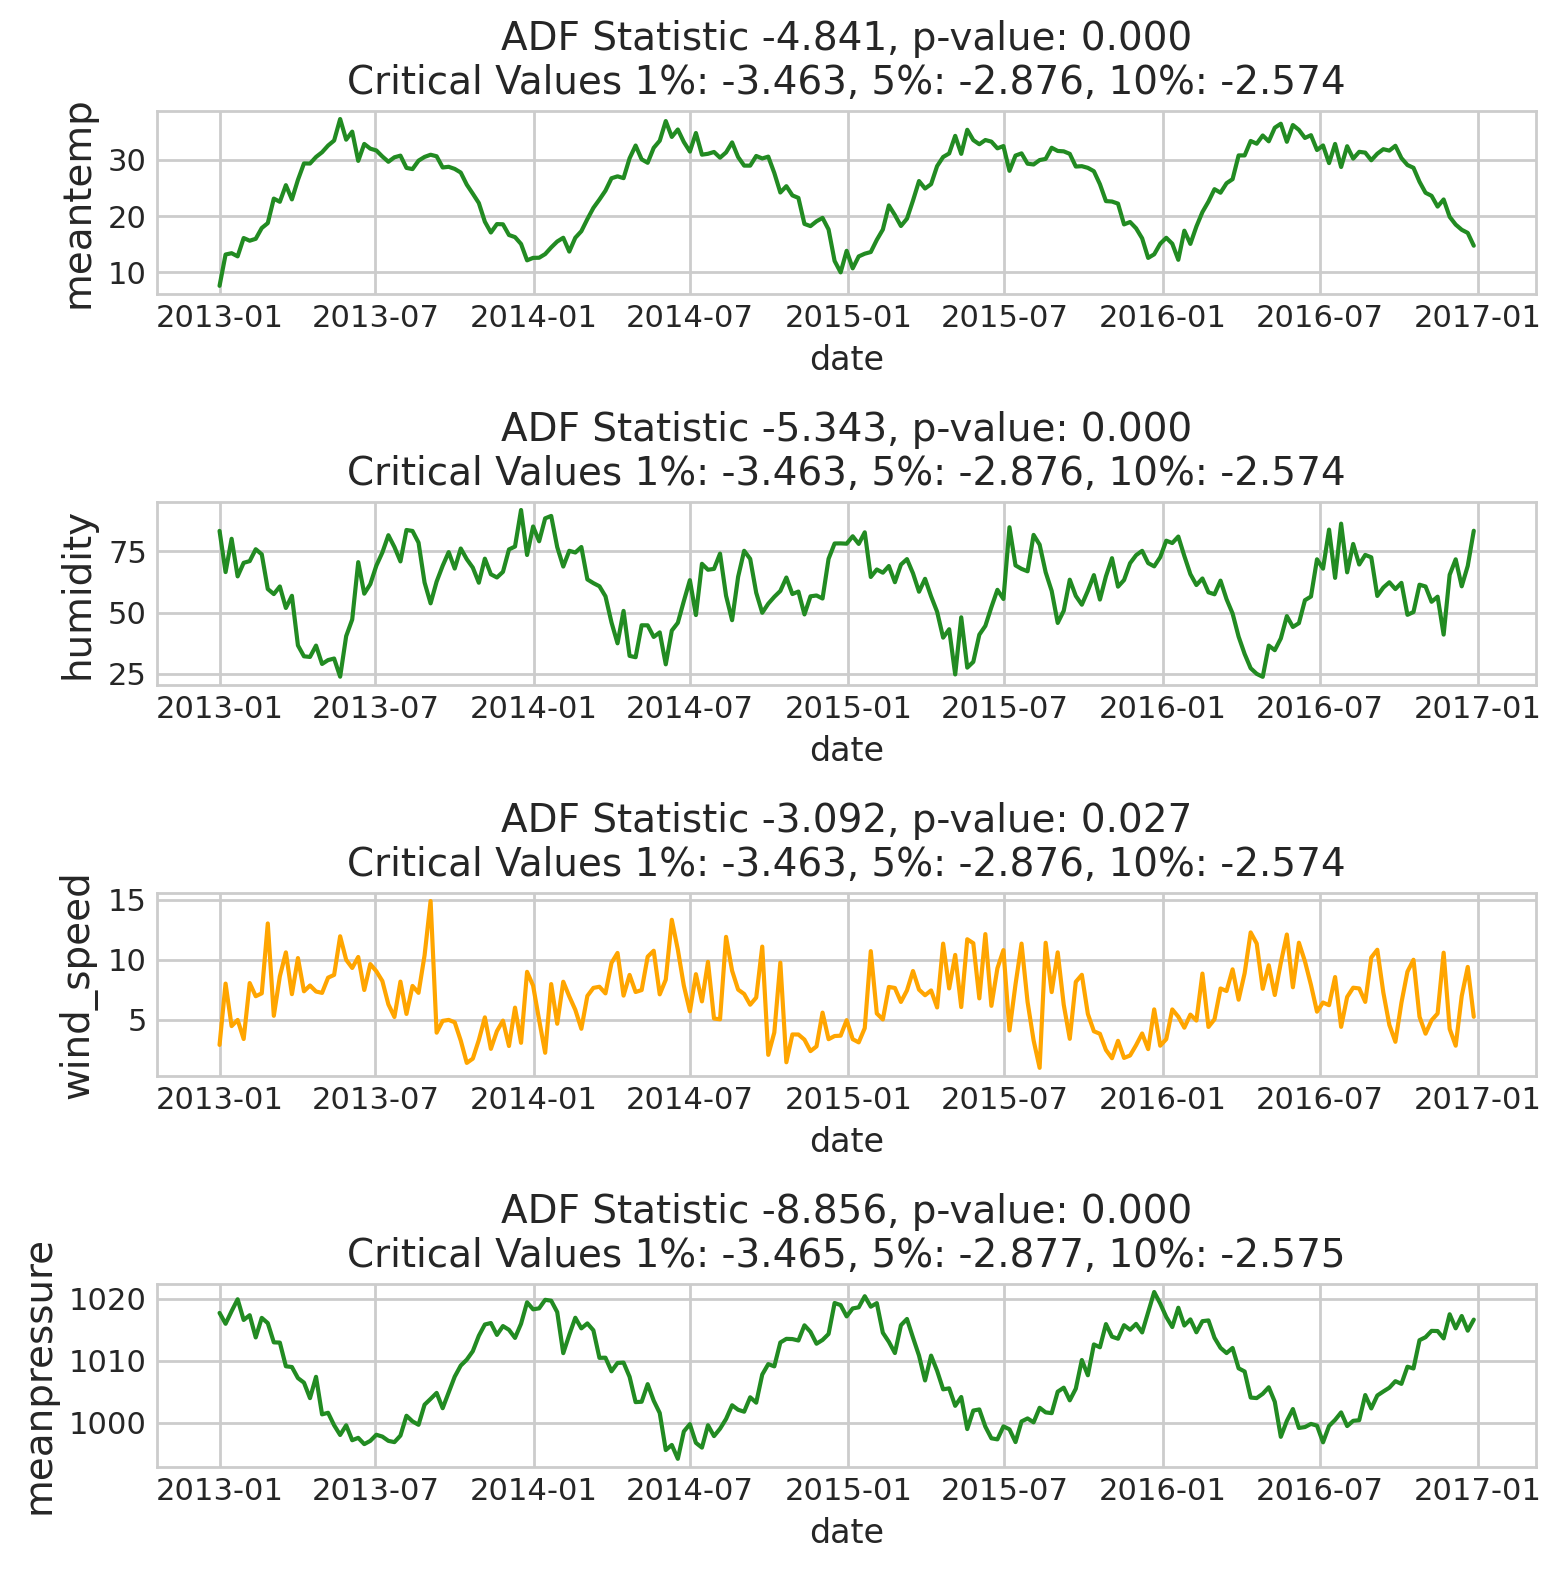

In [25]:
# Plotting Augmented Dickey–Fuller test results for each column
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8))

visualize_adfuller_results(df['meantemp'].values, 'meantemp', ax[0])
visualize_adfuller_results(df['humidity'].values, 'humidity', ax[1])
visualize_adfuller_results(df['wind_speed'].values, 'wind_speed', ax[2])
visualize_adfuller_results(df['meanpressure'].values, 'meanpressure', ax[3])

plt.tight_layout()

It appears that all of our time series are stationary and do not need to be transformed in order to be fed to the ARIMA model.

We will now decompose our time series to gain a more detailed insight.

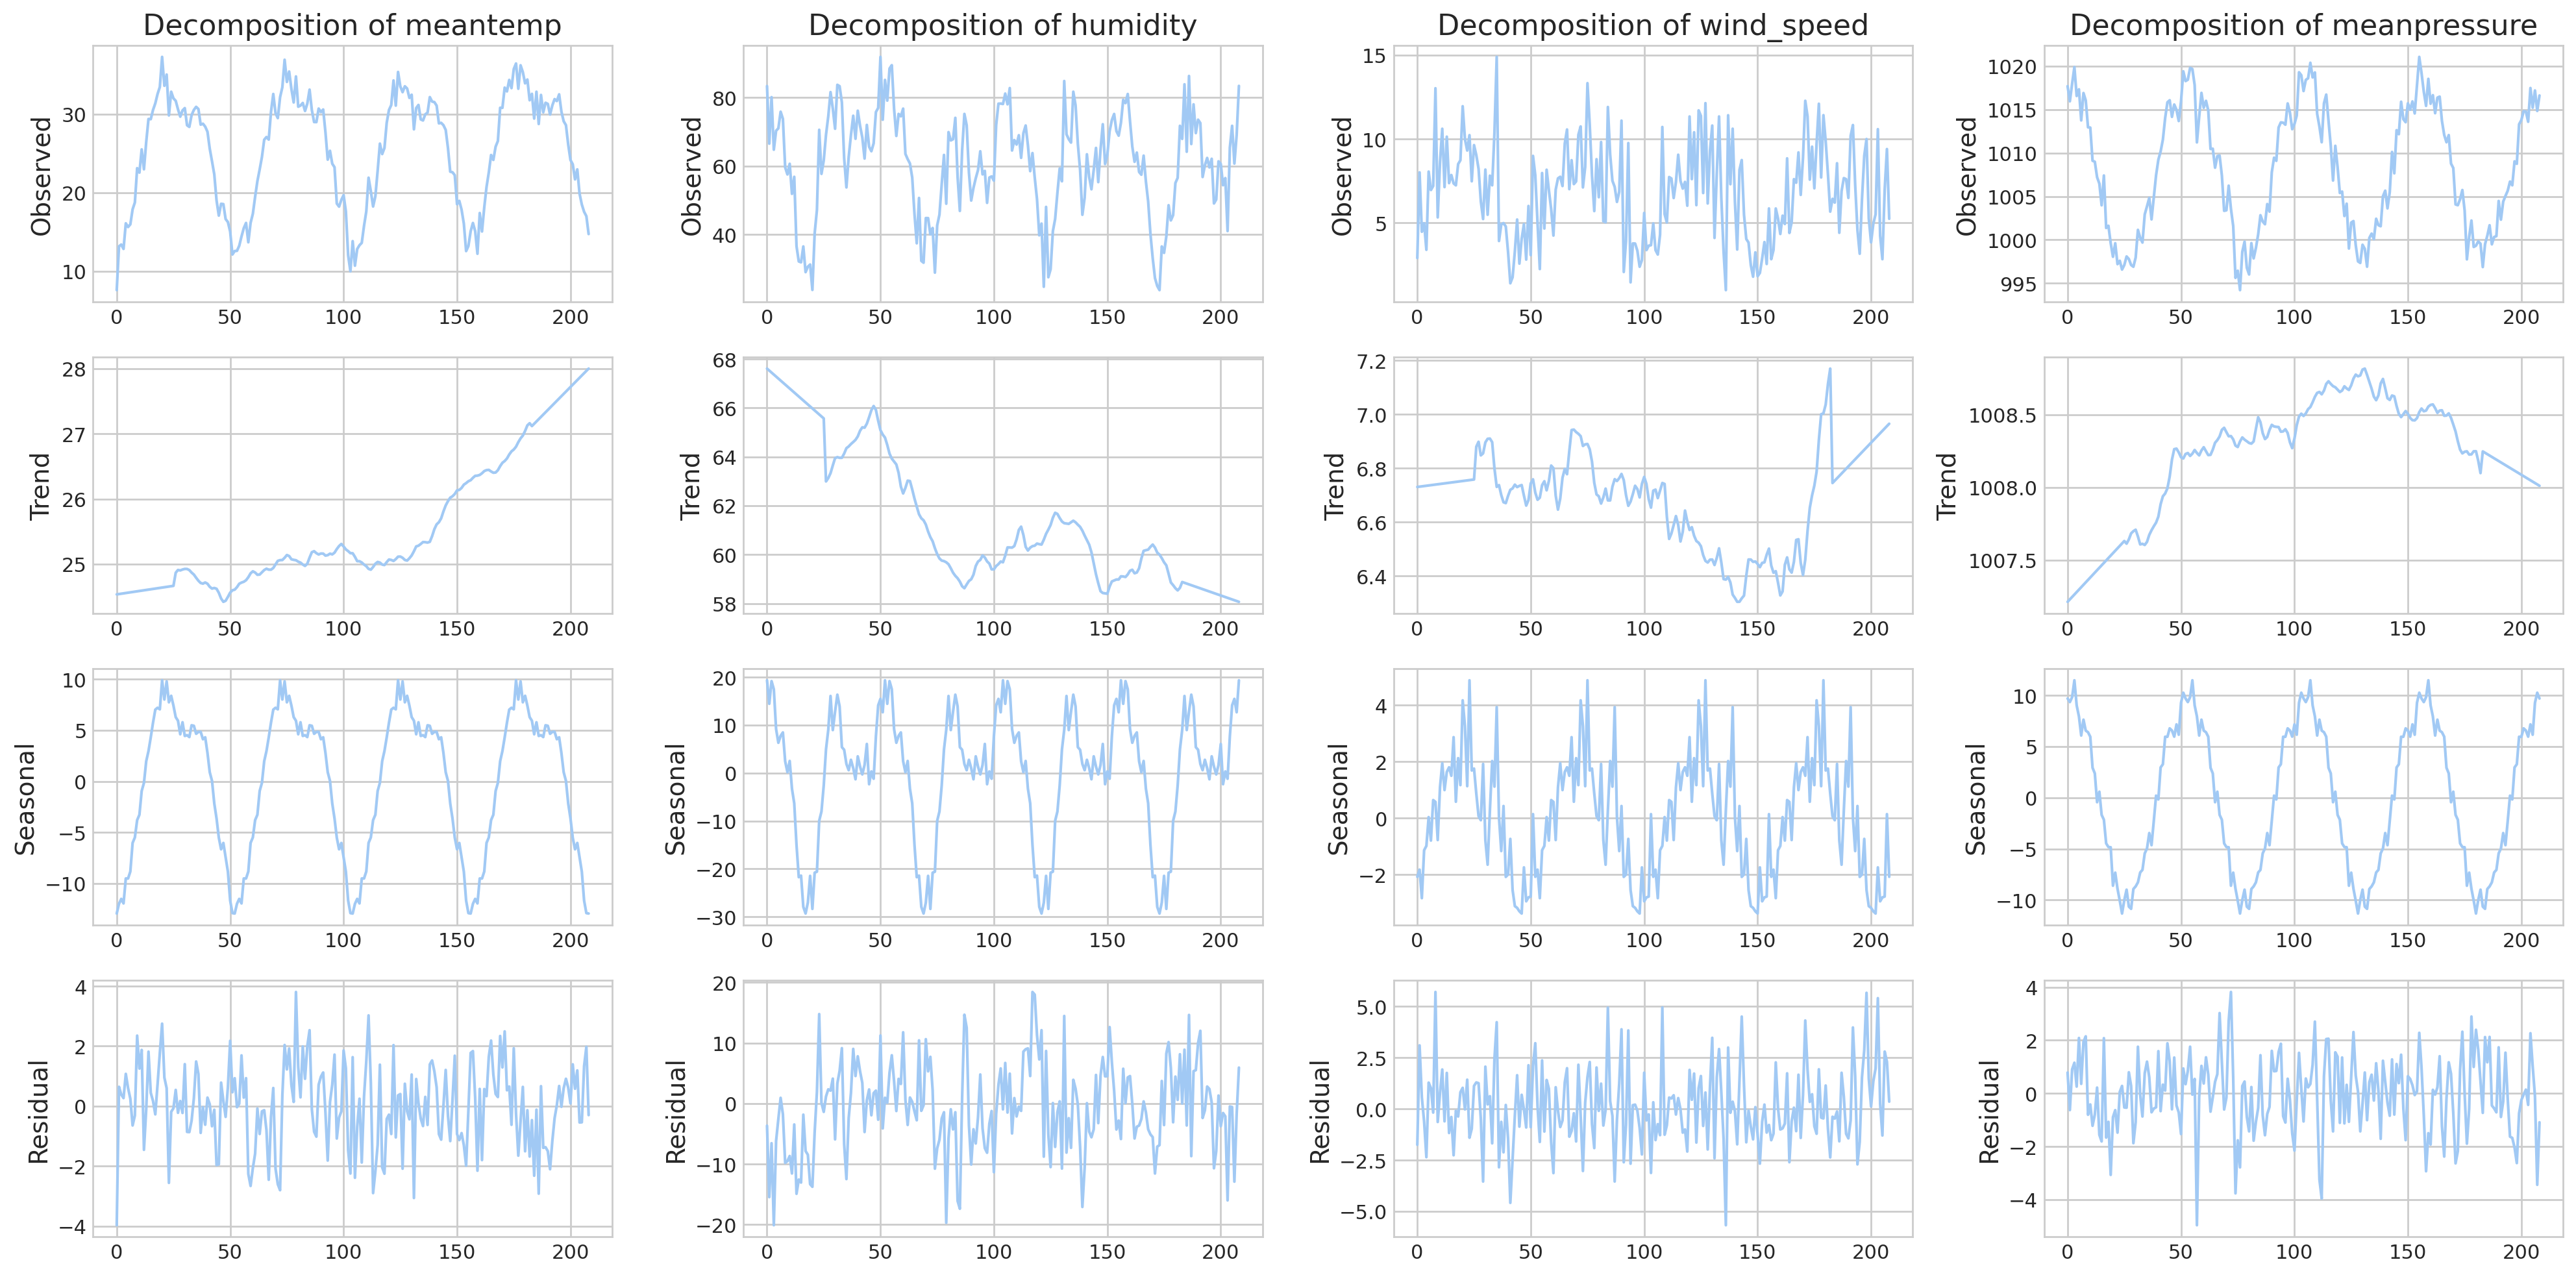

In [26]:
# Decomposing time series 
columns=['meantemp','humidity','wind_speed','meanpressure']

fig, ax =plt.subplots(nrows=4,ncols=4,figsize=(20,10))

for i, column in enumerate(columns):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    
    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False)
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False)
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False)
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False)
    ax[3,i].set_ylabel('Residual', fontsize=14)
    
plt.tight_layout()

We can observe that the trends show very little variation across all features, while seasonality is prominent in all features.

Let's take a closer look at the seasonality of each column.

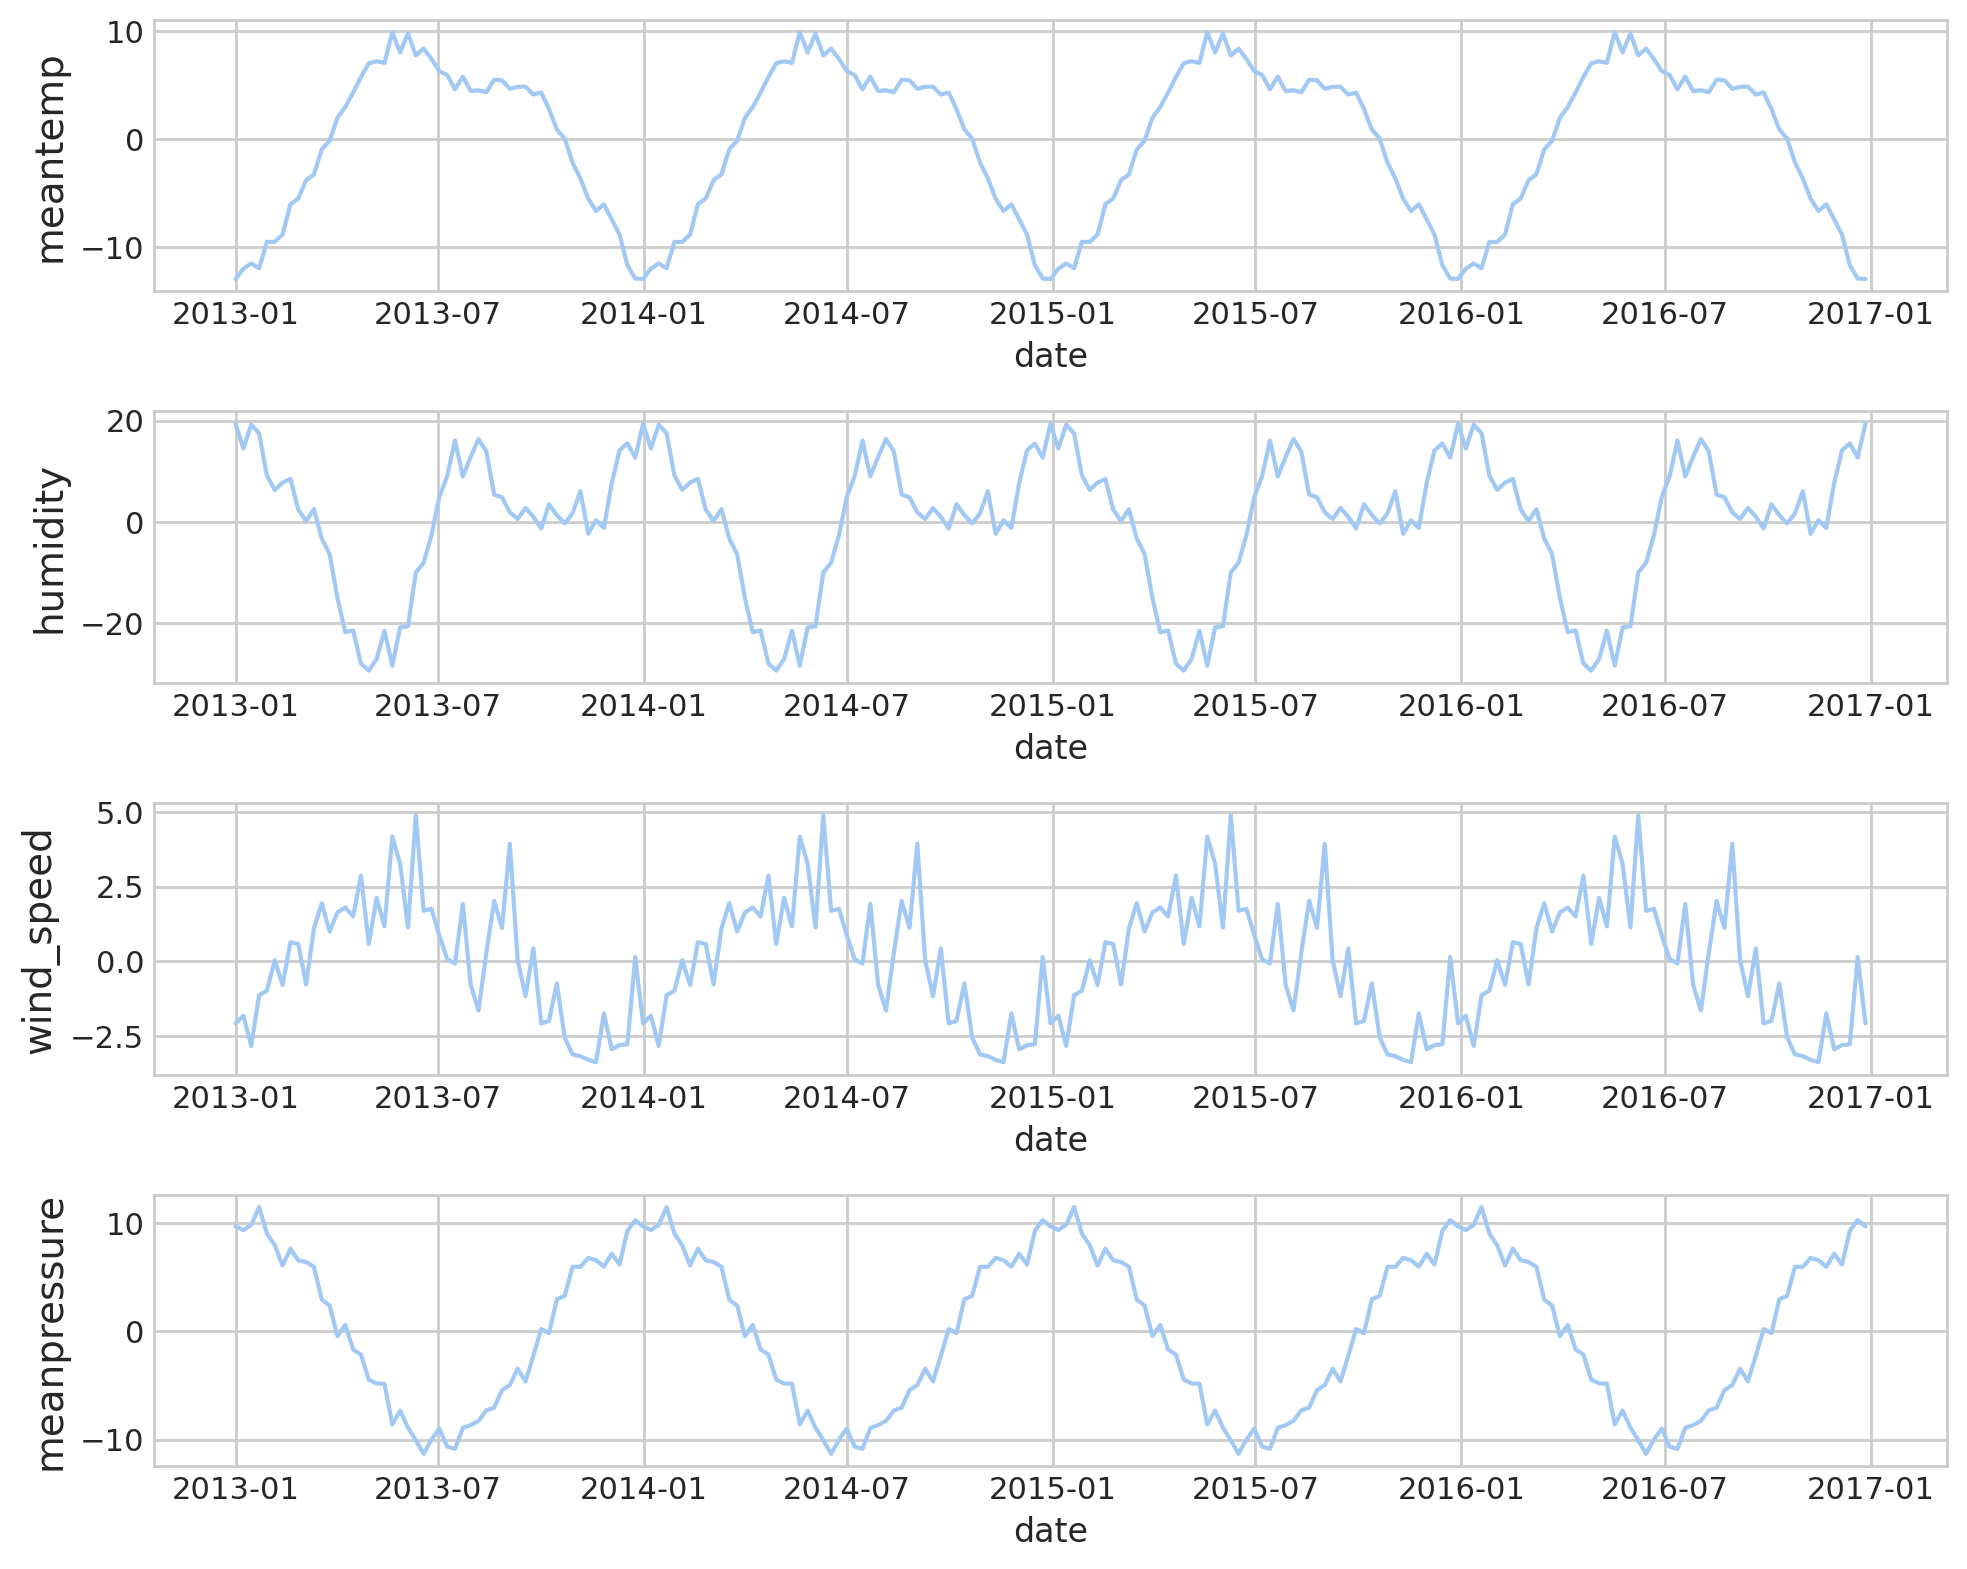

In [27]:
# Plotting only seasonality for each column
for column in columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal
    
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,8))

for i, column in enumerate(columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i])
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    
plt.tight_layout()

We can observe a negative correlation between humidity and pressure with increasing temperatures and wind speed. The weather patterns also appear to match the description provided in the 'What kind of climate does Delhi have?' section.

Lastly, let's plot a correlation heatmap to provide further evidence for the correlation observed earlier between humidity, pressure, temperature, and wind speed.

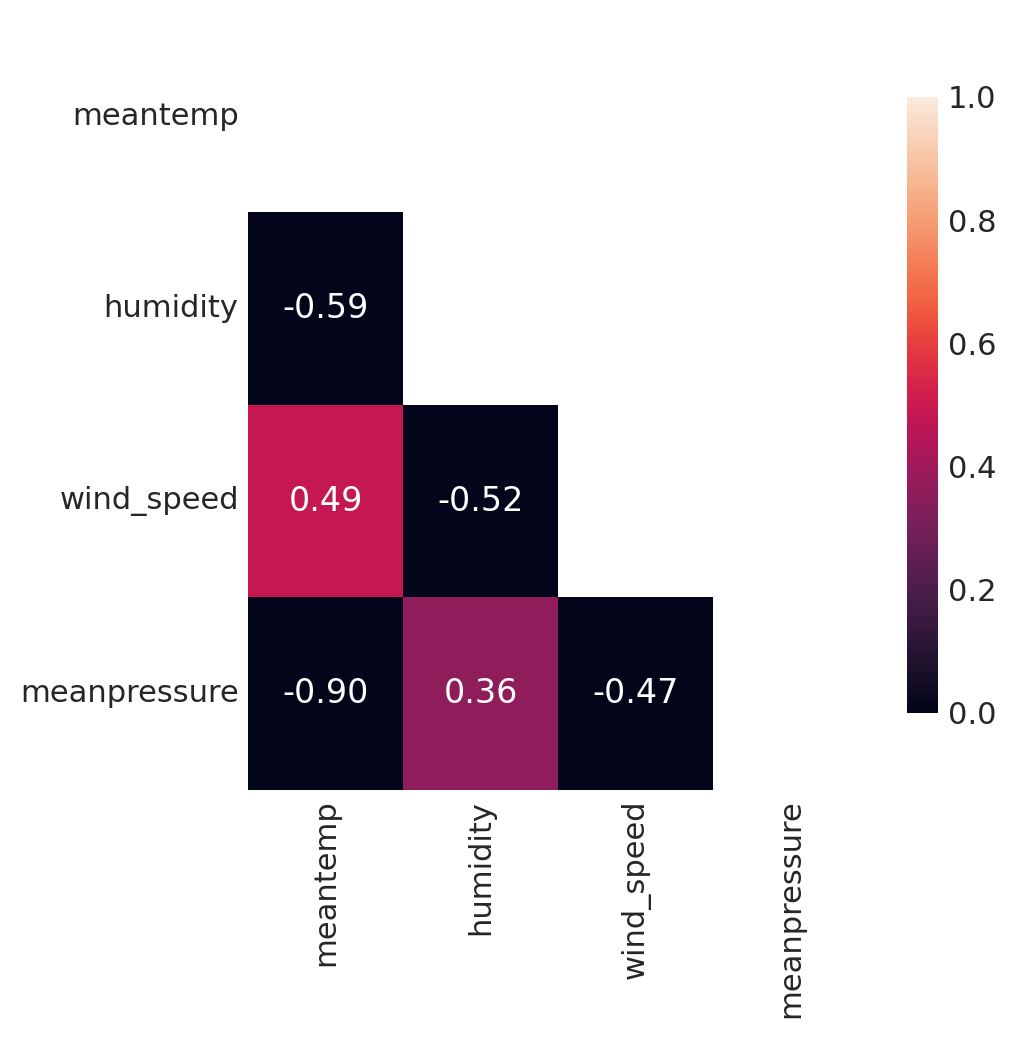

In [28]:
# Plotting correlation heatmap of the dataset
corr=df[columns].corr()
mask= np.triu(np.ones_like(corr,dtype=np.bool))
fig,ax= plt.subplots(figsize=(5,5))
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)
None

# Model building and evaluation 

We will use the ARIMA model to perform univariate time series forecasts and the Prophet model for multivariate time series forecasts. **Our objective is to predict HUMIDTY for the next 32 weeks.**

Let's begin by defining the size of our training set.

In [29]:
# Defining training dataset size (85%)
train_size = int(0.85 * len(df))

## Univariate time series forecasts using ARIMA

In [30]:
# Defining univariate Dataframe - Target = humidity
univariate_df=df[['date', 'humidity']].copy()
univariate_df.columns = ['ds', 'y']

In [31]:
# Train - Validation split
train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

In [32]:
# Tunning ARIMA model with AutoArima  
model = pm.auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1967.723, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1290.991, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1773.679, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1283.688, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1285.465, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1285.565, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1640.820, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1285.634, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1274.339, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1380.066, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1276.393, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1275.003, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1275.369, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

In [33]:
# Defining and fiting ARIMA model 
model = ARIMA(y_train, order=(2,0,0),trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  177
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -632.823
Date:                Tue, 07 Mar 2023   AIC                           1273.646
Time:                        03:45:05   BIC                           1286.350
Sample:                             0   HQIC                          1278.798
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4300      4.365     13.844      0.000      51.874      68.986
ar.L1          0.6978      0.073      9.533      0.000       0.554       0.841
ar.L2          0.1650      0.070      2.342      0.0

In [34]:
# Prediction with ARIMA
y_pred = model_fit.forecast(32)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 13.415552116744601


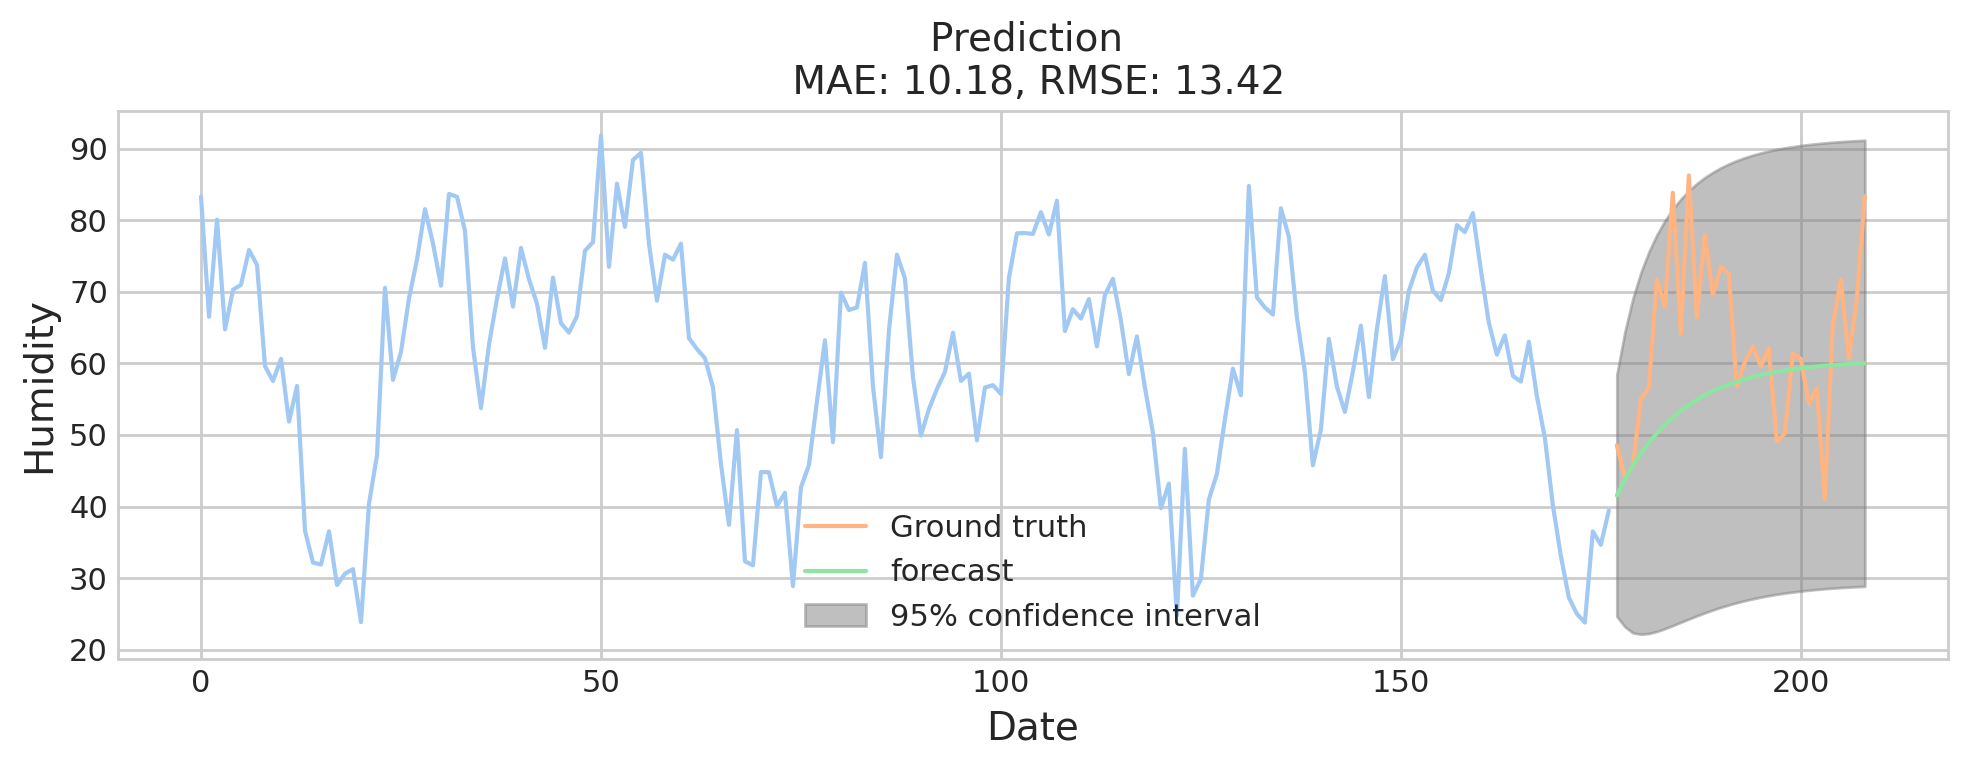

In [35]:
# Plotting forecast - ARIMA univariate analysis 
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth') 
plot_predict(model_fit,177, 208, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Humidity', fontsize=14)

plt.tight_layout()

## Multivariate time series forecasts using Prophet

In [36]:
# Defining multivariate Dataframe - Target = humidity
features= ['meantemp',
          'wind_speed',
          'meanpressure']

target=['humidity']

multivariate_df= df[['date'] + target + features].copy()
multivariate_df.columns = ['ds', 'y'] + features

multivariate_df.head(5).append(multivariate_df.tail(5))

,ds,y,meantemp,wind_speed,meanpressure
0,2013-01-01,83.295238,7.604762,2.903810,1017.685714
1,2013-01-08,66.511905,13.176871,8.013265,1015.942177
2,2013-01-15,80.068027,13.409524,4.471905,1017.972789
3,2013-01-22,64.748299,12.848639,4.981973,1019.884694
4,2013-01-29,70.279592,16.107653,3.396378,1016.554592
204,2016-11-29,65.384536,19.883387,4.234881,1017.473212
205,2016-12-06,71.711197,18.500047,2.837198,1015.210392
206,2016-12-13,60.698526,17.578005,6.974330,1017.191007
207,2016-12-20,69.026283,17.020965,9.403279,1014.833210
208,2016-12-27,83.352881,14.742226,5.245749,1016.612457


In [37]:
# Train - Validation split
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

In [38]:
# Train the model
model = Prophet()
model.add_regressor('meantemp')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

03:45:07 - cmdstanpy - INFO - Chain [1] start processing
03:45:07 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 6.210857759697502


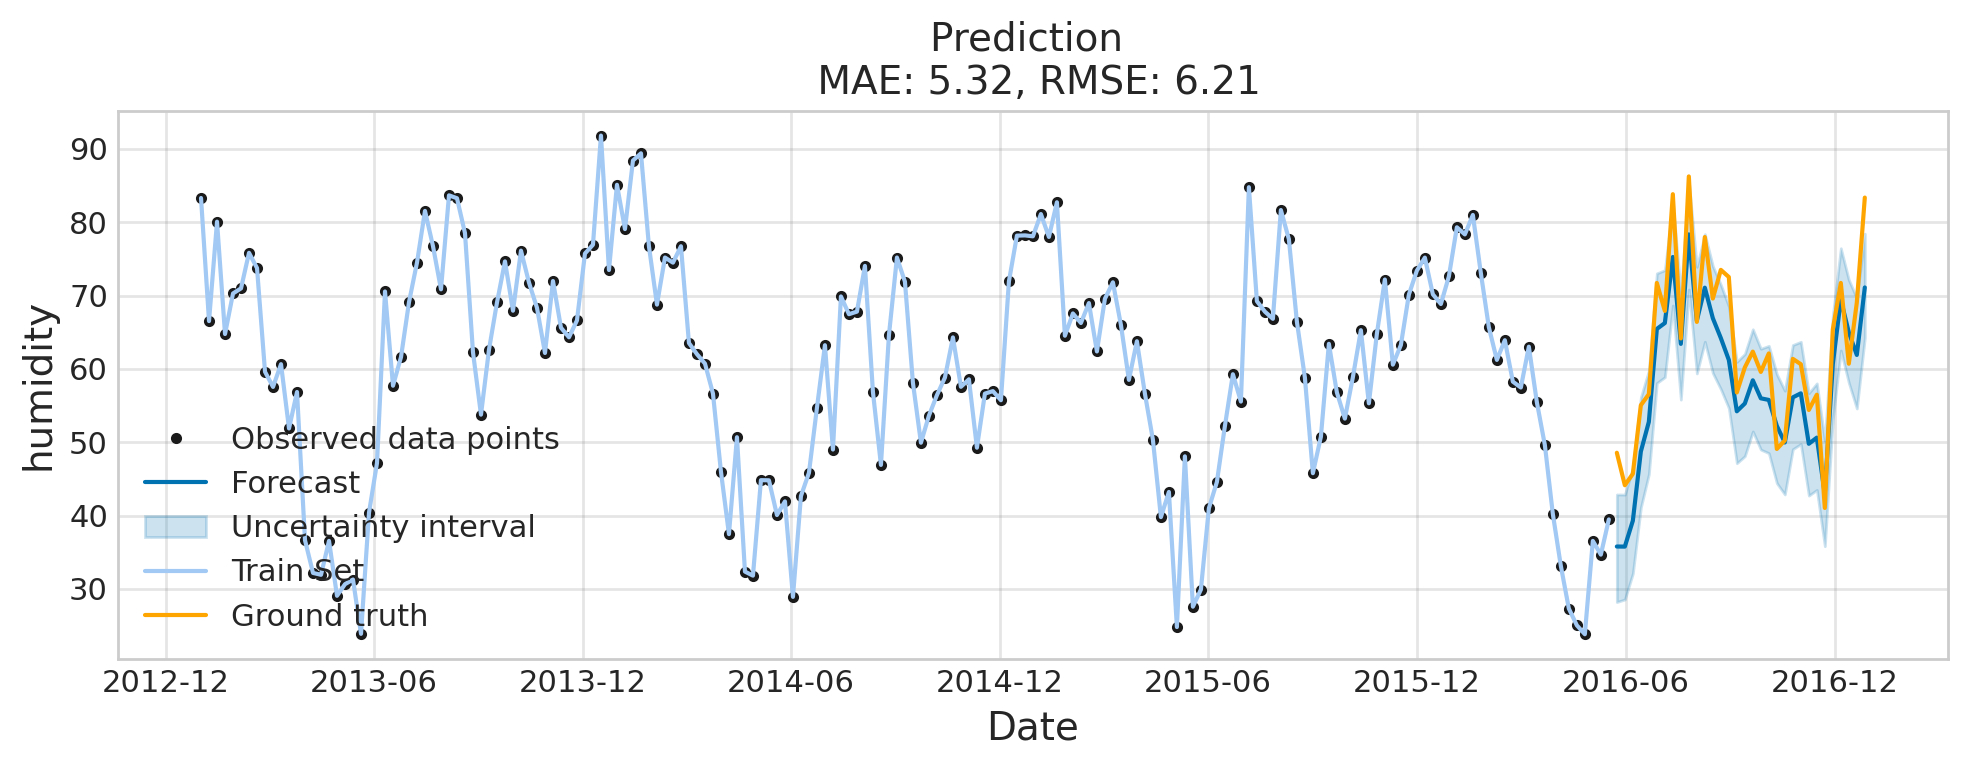

In [39]:
# Plotting forecast - Prophet multivariate analysis 
fig, ax = plt.subplots(figsize=(10, 4))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, label='Train Set')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='humidity', fontsize=14)

plt.tight_layout()

## Afterword

Our experiments show that the multivariate time series forecasting approach with Prophet outperformed the univariate ARIMA model for this dataset.